In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from decimal import Decimal
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

In [ ]:
data = pd.read_csv("/content/sample_data/FallDataset_final.csv",sep=';')
TIME_COLS = [col for col in data.columns if col.startswith('Time')] # list comprehension

In [ ]:
data.head()

,Falls,Time 1,Time 2,Time 3,Time 4,Time 5,Time 6,Time 7,Time 8,Time 9,...,Time 272,Time 273,Time 274,Time 275,Time 276,Time 277,Time 278,Time 279,Time 280,isFall
0,1,104230,104230,106260,101860,102760,106260,106260,112670,111860,...,111860,111860,106260,101860,95040,95360,96640,108530,110490,1
1,2,111040,106260,110490,105110,106260,96640,99440,96640,98820,...,86290,89080,84140,81560,73700,70750,72030,70310,77340,1
2,3,87350,78130,70750,73700,84140,81560,84510,86290,77340,...,87350,94070,85940,93750,94070,89080,91440,87350,91110,1
3,4,125000,128850,115350,121530,115350,119510,118220,111860,110490,...,109650,115350,101860,101860,106260,98820,106260,116140,110490,1
4,5,87350,91110,97890,101860,100050,98820,95040,94070,96640,...,133500,132810,139750,138220,126210,125240,138440,139100,139750,1


In [ ]:
data["isFall"].value_counts()

1    200
0    128
Name: isFall, dtype: int64

In [ ]:
def divide_by_10e5(dataframe):
    divisor = Decimal(10**5)
    dataframe[TIME_COLS] = dataframe[TIME_COLS].div(divisor)
    return dataframe

In [ ]:
divide_by_10e5(data)

data.head()

,Falls,Time 1,Time 2,Time 3,Time 4,Time 5,Time 6,Time 7,Time 8,Time 9,...,Time 272,Time 273,Time 274,Time 275,Time 276,Time 277,Time 278,Time 279,Time 280,isFall
0,1,1.0423,1.0423,1.0626,1.0186,1.0276,1.0626,1.0626,1.1267,1.1186,...,1.1186,1.1186,1.0626,1.0186,0.9504,0.9536,0.9664,1.0853,1.1049,1
1,2,1.1104,1.0626,1.1049,1.0511,1.0626,0.9664,0.9944,0.9664,0.9882,...,0.8629,0.8908,0.8414,0.8156,0.737,0.7075,0.7203,0.7031,0.7734,1
2,3,0.8735,0.7813,0.7075,0.737,0.8414,0.8156,0.8451,0.8629,0.7734,...,0.8735,0.9407,0.8594,0.9375,0.9407,0.8908,0.9144,0.8735,0.9111,1
3,4,1.25,1.2885,1.1535,1.2153,1.1535,1.1951,1.1822,1.1186,1.1049,...,1.0965,1.1535,1.0186,1.0186,1.0626,0.9882,1.0626,1.1614,1.1049,1
4,5,0.8735,0.9111,0.9789,1.0186,1.0005,0.9882,0.9504,0.9407,0.9664,...,1.335,1.3281,1.3975,1.3822,1.2621,1.2524,1.3844,1.391,1.3975,1


In [ ]:
def plot_row(dataframe, row_idx=0):
  selected_row = data.iloc[row_idx]
  time_values = [selected_row[col] for col in TIME_COLS]

  plt.plot(range(len(time_values)), time_values)

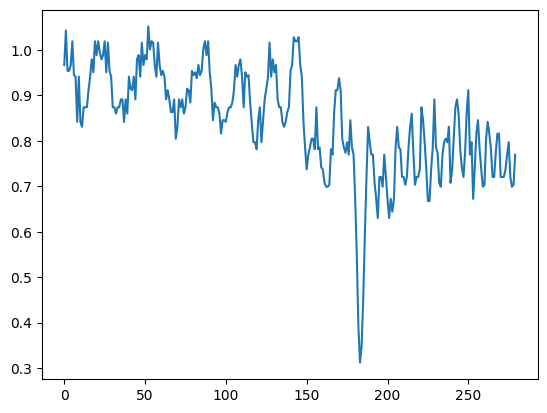

In [ ]:
plot_row(data, 5)

In [ ]:
data['isFall'].value_counts()

1    200
0    128
Name: isFall, dtype: int64

In [ ]:
data.dtypes

Falls        int64
Time 1      object
Time 2      object
Time 3      object
Time 4      object
             ...  
Time 277    object
Time 278    object
Time 279    object
Time 280    object
isFall       int64
Length: 282, dtype: object

In [ ]:
def preprocess_dtypes(dataframe):
    dataframe['isFall'] = dataframe['isFall'].astype('category')
    dataframe['Falls'] = dataframe['Falls'].astype('object')

    dataframe[TIME_COLS] = dataframe[TIME_COLS].astype(float)

    return dataframe

In [ ]:
data = preprocess_dtypes(data)
data.dtypes

Falls         object
Time 1       float64
Time 2       float64
Time 3       float64
Time 4       float64
              ...   
Time 277     float64
Time 278     float64
Time 279     float64
Time 280     float64
isFall      category
Length: 282, dtype: object

In [ ]:
print(f"Shape before dropna: {data.shape}")
null_counts = data.isnull().sum(axis=0)
print(null_counts)
nonzero_null_counts = null_counts[null_counts != 0]
print(nonzero_null_counts)
data = data.dropna()
print(f"Shape after dropna: {data.shape}")

Shape before dropna: (328, 282)
Falls       0
Time 1      0
Time 2      0
Time 3      0
Time 4      0
           ..
Time 277    0
Time 278    0
Time 279    0
Time 280    0
isFall      0
Length: 282, dtype: int64
Series([], dtype: int64)
Shape after dropna: (328, 282)


In [ ]:
def standardize(dataframe):
    scaler = StandardScaler()
    dataframe[TIME_COLS] = scaler.fit_transform(dataframe[TIME_COLS])
    return dataframe

In [ ]:
standardized_data = standardize(data)

In [ ]:
standardized_data.head()

,Falls,Time 1,Time 2,Time 3,Time 4,Time 5,Time 6,Time 7,Time 8,Time 9,...,Time 272,Time 273,Time 274,Time 275,Time 276,Time 277,Time 278,Time 279,Time 280,isFall
0,1,-0.087337,-0.086856,-0.017191,-0.147214,-0.104121,-0.005137,-0.007984,0.182418,0.131719,...,-0.055325,-0.055104,-0.184729,-0.262273,-0.437908,-0.433299,-0.402642,-0.115765,-0.080606,1
1,2,0.094618,-0.031993,0.094368,-0.058774,-0.010027,-0.261625,-0.193357,-0.245532,-0.228225,...,-0.651305,-0.571614,-0.698258,-0.731924,-0.926247,-1.003849,-0.972369,-0.993312,-0.848854,1
2,3,-0.538353,-0.792235,-0.953703,-0.913510,-0.604705,-0.663686,-0.599165,-0.521843,-0.821139,...,-0.626599,-0.458472,-0.656470,-0.449902,-0.460105,-0.578892,-0.523023,-0.602067,-0.529735,1
3,4,0.467614,0.578525,0.222542,0.388051,0.234351,0.348133,0.317097,0.160794,0.093903,...,-0.106835,0.024027,-0.286877,-0.262273,-0.181152,-0.353083,-0.179936,0.058964,-0.080606,1
4,5,-0.538353,-0.441437,-0.237935,-0.147214,-0.176978,-0.203502,-0.312952,-0.314142,-0.288400,...,0.449056,0.419913,0.592763,0.578934,0.275379,0.259430,0.565039,0.586136,0.597491,1


In [ ]:
def create_and_evaluate_models(dataframe, log_file_path):
    # Split the data into training and testing sets
    X = dataframe[TIME_COLS]
    y = dataframe['isFall']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)

    # Define the models to evaluate
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC()
    }

    # Define the hyperparameter grids for each model
    param_grids = {
        'Logistic Regression': {'C': [0.1, 1, 10]},
        'Decision Tree': {'max_depth': [None, 5, 10]},
        'Random Forest': {'n_estimators': [50, 100, 200]},
        'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    }

    # Evaluate each model using cross-validation and hyperparameter search
    results = {}
    roc_auc = {}
    best_accuracy = 0.0
    best_model = None
    best_params = None

    # Binarize the labels
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_train)

    y_test_binarized = label_binarizer.transform(y_test)

    for model_name, model in models.items():
        param_grid = param_grids[model_name]
        search = GridSearchCV(model, param_grid, scoring='precision', cv=5)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            search.fit(X_train, y_train)
        y_pred = search.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        results[model_name] = {'best_model': search.best_estimator_, 'accuracy': accuracy,
                               'classification_report': report, 'confusion_matrix': conf_matrix}

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = search.best_estimator_
            best_params = search.best_params_

        plt.figure(figsize=(6, 6))
        y_pred_binarized = label_binarizer.transform(y_pred)


        fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_binarized)
        roc_auc[model_name]=auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve of (area = {auc(fpr, tpr):.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    for result in results:

      sns.heatmap(results[result]["confusion_matrix"],annot=True,cmap='Greens',
                    cbar_kws={"orientation":"vertical","label":"color bar"},
                  xticklabels=['not fall', 'fall'], yticklabels=['not fall', 'fall']
                    )
      plt.xlabel('Predicted labels')
      plt.ylabel('True labels')
      plt.title('Confusion Matrix of '+ result)
      plt.show()

    # plt.figure(figsize=(8, 8))
    # for model_name, _ in models.items():
    #     fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_binarized)
    #     roc_auc[model_name]=auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'ROC curve of (area = {auc(fpr, tpr):.2f})')

    #     plt.plot([0, 1], [0, 1], 'k--')
    #     plt.xlim([0.0, 1.0])
    #     plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    # plt.legend(loc="lower right")
    # plt.show()
      # Return the best model and its best parameters
    return best_model, best_params, results
'''
    # Write model performances to a log file
    with open(log_file_path, 'w') as log_file:
        log_file.write(f"Best Model: {best_model}\n")
        log_file.write(f"Best Parameters: {best_params}\n\n")
        for model_name, result in results.items():
            log_file.write(f"Model: {model_name}\n")
            log_file.write(f"Accuracy: {result['accuracy']}\n")
            log_file.write(f"Classification Report:\n{result['classification_report']}\n\n")

            log_file.write(f"Confusion Matrix:\n")
            log_file.write(f"                  Predicted NO     Predicted YES\n")
            log_file.write(f"Actual NO         {result['confusion_matrix'][0, 0]:<10}     {result['confusion_matrix'][0, 1]:<10}\n")
            log_file.write(f"Actual YES        {result['confusion_matrix'][1, 0]:<10}     {result['confusion_matrix'][1, 1]:<10}\n\n")

            # Calculate TP, FP, TN, FN
            TP = result['confusion_matrix'][1, 1]
            FP = result['confusion_matrix'][0, 1]
            TN = result['confusion_matrix'][0, 0]
            FN = result['confusion_matrix'][1, 0]

            log_file.write(f"True Positives: {TP}\n")
            log_file.write(f"False Positives: {FP}\n")
            log_file.write(f"True Negatives: {TN}\n")
            log_file.write(f"False Negatives: {FN}\n\n")

            log_file.write("---------------------------------\n")*#
'''


'\n    # Write model performances to a log file\n    with open(log_file_path, \'w\') as log_file:\n        log_file.write(f"Best Model: {best_model}\n")\n        log_file.write(f"Best Parameters: {best_params}\n\n")\n        for model_name, result in results.items():\n            log_file.write(f"Model: {model_name}\n")\n            log_file.write(f"Accuracy: {result[\'accuracy\']}\n")\n            log_file.write(f"Classification Report:\n{result[\'classification_report\']}\n\n")\n\n            log_file.write(f"Confusion Matrix:\n")\n            log_file.write(f"                  Predicted NO     Predicted YES\n")\n            log_file.write(f"Actual NO         {result[\'confusion_matrix\'][0, 0]:<10}     {result[\'confusion_matrix\'][0, 1]:<10}\n")\n            log_file.write(f"Actual YES        {result[\'confusion_matrix\'][1, 0]:<10}     {result[\'confusion_matrix\'][1, 1]:<10}\n\n")\n\n            # Calculate TP, FP, TN, FN\n            TP = result[\'confusion_matrix\'][1, 1]\n    

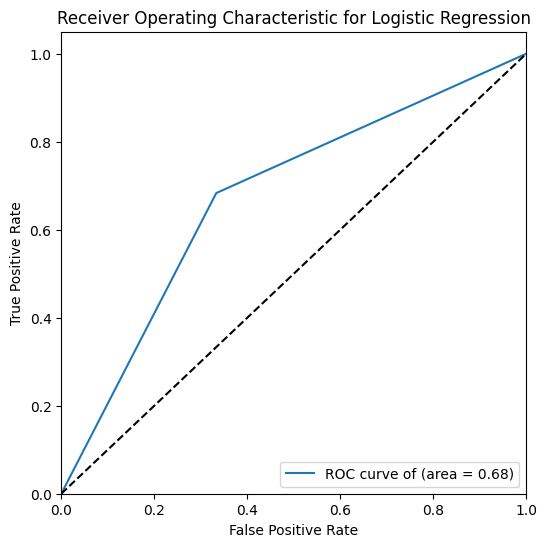

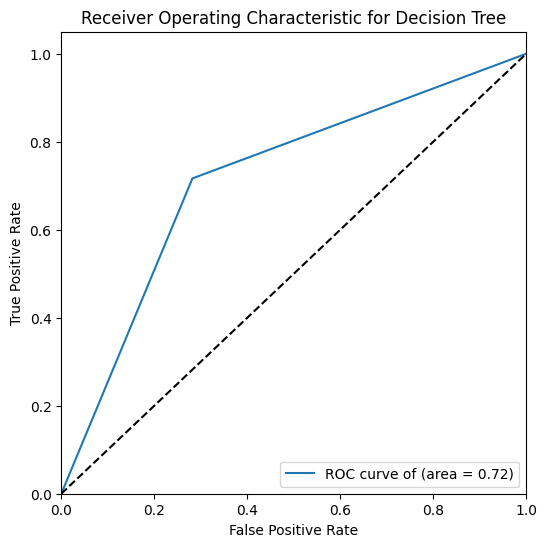

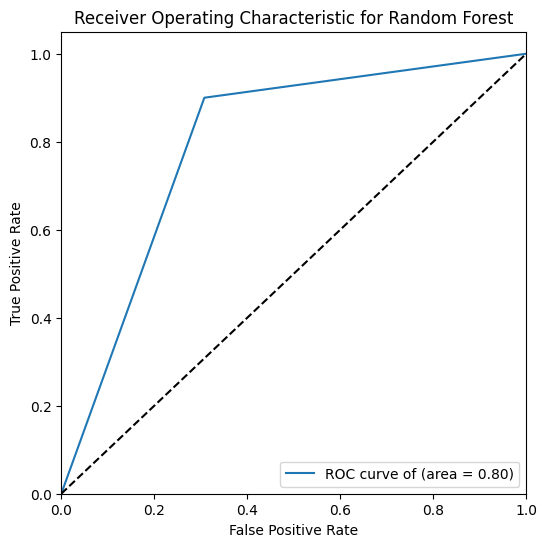

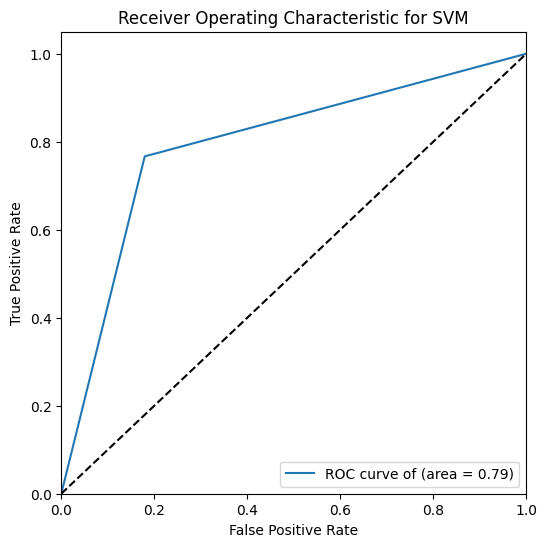

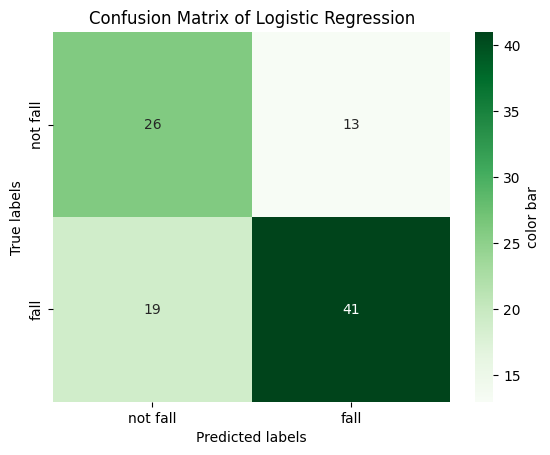

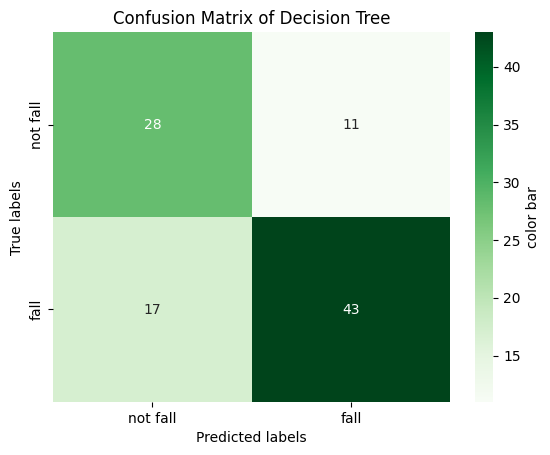

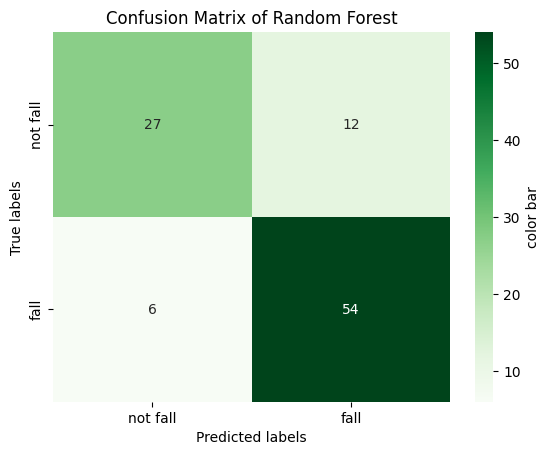

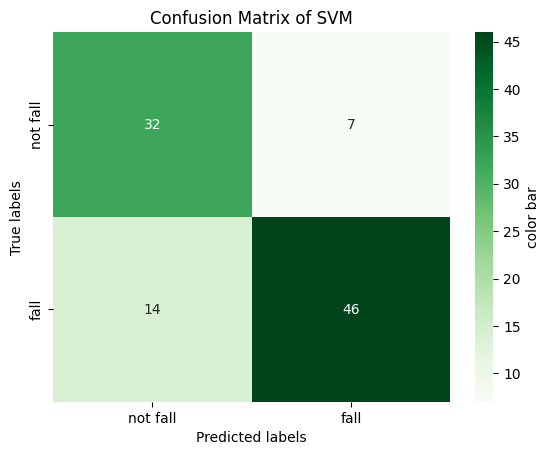

In [ ]:
log_file_path = 'model_performance.log'
best_model, best_params, out_results = create_and_evaluate_models(data, log_file_path)

In [ ]:
df=pd.DataFrame(out_results)
df

,Logistic Regression,Decision Tree,Random Forest,SVM
best_model,LogisticRegression(C=0.1),DecisionTreeClassifier(max_depth=5),"(DecisionTreeClassifier(max_features='sqrt', r...",SVC(C=10)
accuracy,0.707071,0.787879,0.787879,0.787879
classification_report,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...
confusion_matrix,"[[22, 17], [12, 48]]","[[25, 14], [7, 53]]","[[25, 14], [7, 53]]","[[26, 13], [8, 52]]"


In [ ]:
lg=out_results["Logistic Regression"]["confusion_matrix"]

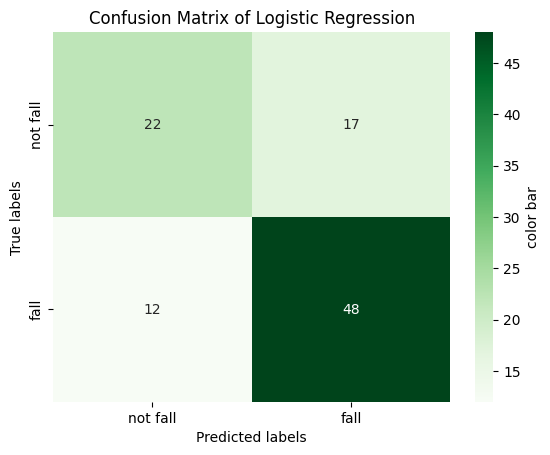

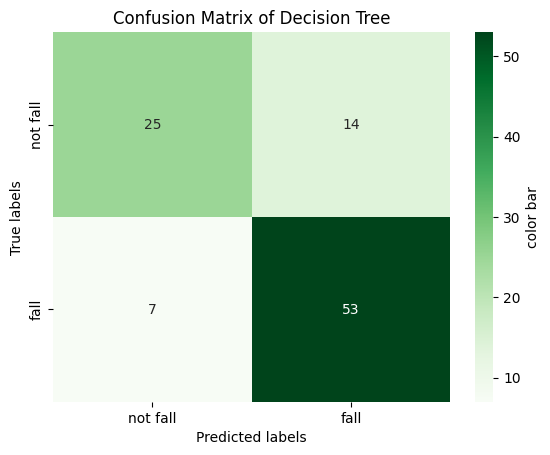

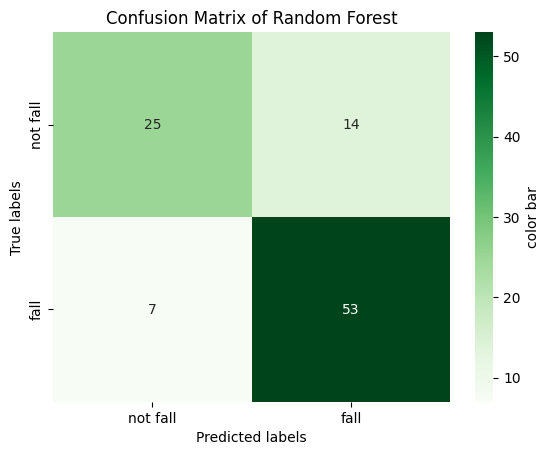

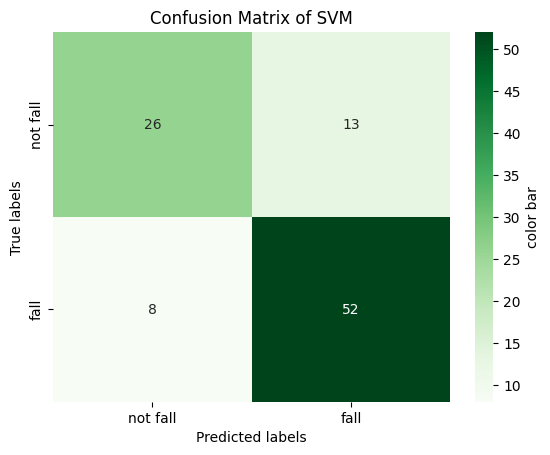

In [ ]:
for out_result in out_results:
    sns.heatmap(out_results[out_result]["confusion_matrix"],annot=True,cmap='Greens',
                  cbar_kws={"orientation":"vertical","label":"color bar"},
                xticklabels=['not fall', 'fall'], yticklabels=['not fall', 'fall']
                  )
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix of '+ out_result)
    plt.show()

[Text(0.4791666666666667, 0.9166666666666666, 'Time 115 <= -0.251\ngini = 0.475\nsamples = 229\nvalue = [89, 140]\nclass = Yes Fall'),
 Text(0.1875, 0.75, 'Time 73 <= -1.106\ngini = 0.269\nsamples = 100\nvalue = [16, 84]\nclass = Yes Fall'),
 Text(0.08333333333333333, 0.5833333333333334, 'Time 151 <= -0.867\ngini = 0.497\nsamples = 13\nvalue = [7, 6]\nclass = No Fall'),
 Text(0.041666666666666664, 0.4166666666666667, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]\nclass = No Fall'),
 Text(0.125, 0.4166666666666667, 'Time 199 <= -1.059\ngini = 0.245\nsamples = 7\nvalue = [1, 6]\nclass = Yes Fall'),
 Text(0.08333333333333333, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = No Fall'),
 Text(0.16666666666666666, 0.25, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]\nclass = Yes Fall'),
 Text(0.2916666666666667, 0.5833333333333334, 'Time 120 <= -0.479\ngini = 0.185\nsamples = 87\nvalue = [9, 78]\nclass = Yes Fall'),
 Text(0.25, 0.4166666666666667, 'gini = 0.0\nsamples = 59\nvalue = [0, 59]\nclas

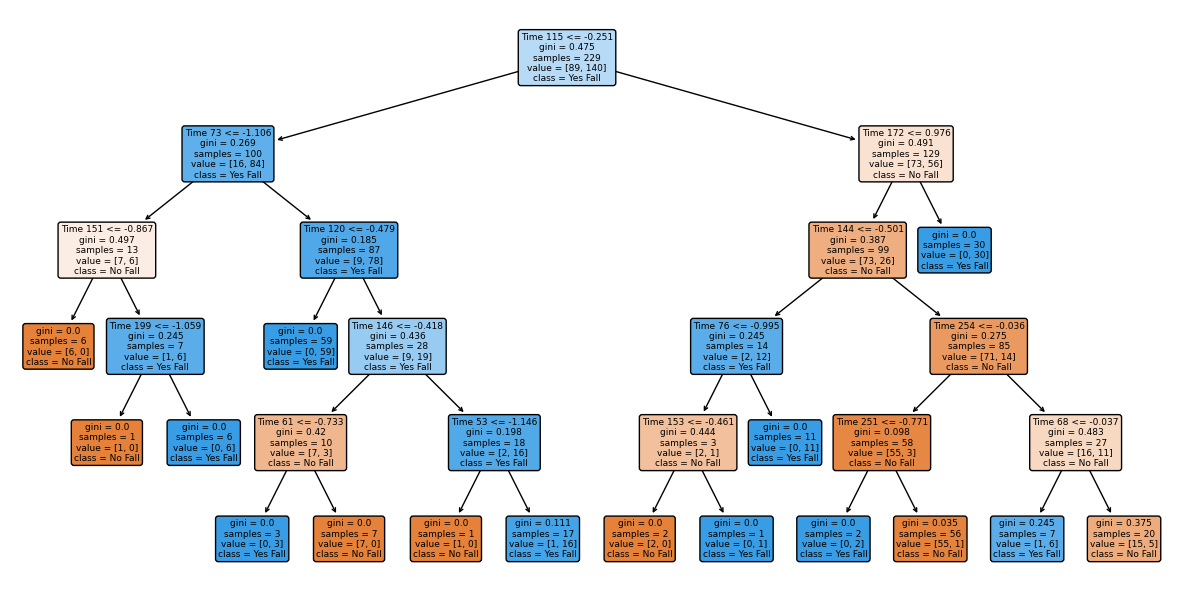

In [ ]:
plt.figure(figsize=(15,7.5))
plot_tree(out_results["Decision Tree"]["best_model"],
          filled=True,
          rounded=True,
          class_names=["No Fall", "Yes Fall"],
          feature_names=data.columns)

In [ ]:
new_X = data[TIME_COLS].iloc[[-1]]
new_X

,Time 1,Time 2,Time 3,Time 4,Time 5,Time 6,Time 7,Time 8,Time 9,Time 10,...,Time 271,Time 272,Time 273,Time 274,Time 275,Time 276,Time 277,Time 278,Time 279,Time 280
327,-0.614235,-0.571702,-0.779904,-0.993786,-0.988074,-1.058548,-0.881573,-0.678286,-0.756824,-0.758647,...,-1.028589,-0.85991,-0.910815,-1.019331,-1.128466,-0.926247,-0.935458,-0.795501,-0.95382,-0.971912


In [ ]:
def predict_pipeline(original_dataframe, dataframe, best_model):
    # Select the time columns for prediction
    X_org = original_dataframe[TIME_COLS]
    X = dataframe[TIME_COLS]

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the features using the scaler
    scaler.fit(X_org)
    X_scaled = scaler.transform(X)

    # Make predictions using the best model
    predictions = best_model.predict(X_scaled)

    return predictions


In [ ]:
print(predict_pipeline(data, data.iloc[[0]], best_model))


[1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
